<a href="https://colab.research.google.com/github/shivammehta007/Social-Network-Analysis/blob/master/Demographic_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import scipy.sparse as sp
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline
# Setting up custom random seeds,
SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)


## Opening Data

In [0]:
data_path = os.path.join('drive', 'My Drive', 'Colab Notebooks', 'SNA Lab', 'SNA-Lab3')
file_london = pd.read_csv(os.path.join(data_path, 'LondonTrain.csv'))
file_newyork = pd.read_csv(os.path.join(data_path, 'NYTrain.csv'))
file_singapore = pd.read_csv(os.path.join(data_path, 'SingaporeTrain.csv'))

## EDA: Exploratory Data Analysis

### Heads

In [0]:
# Dropping Row ID
file_london.drop(['row ID'], axis=1, inplace=True)
file_newyork.drop(['row ID'], axis=1, inplace=True)
file_singapore.drop(['row ID'], axis=1, inplace=True)

In [7]:
file_london.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Edenred Employee Benefits Advisor November 20...,female,NaN,NaN,NaN,NaN,personal care and service,NaN
2,"Uppsala University Egyptology Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN
4,University of Verona 2008 to 2010 Nursing Ve...,Coogee Pavilion Pizza Chef 13 April 2015 to p...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN


In [8]:
file_newyork.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,Universidad Santo Toms Class of 2009 Psycholo...,GMO Chile Analista de Seleccin y Desarrollo A...,female,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,male,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,male,NaN,NaN,in a relationship,NaN,NaN,NaN
3,NaN,Commonwealth of Massachusetts Legislative Aide...,male,NaN,NaN,NaN,NaN,healthcare support,NaN
4,NaN,Mindshare Pan Regional Director 1 October 201...,female,NaN,NaN,NaN,NaN,management,NaN


In [9]:
file_singapore.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN
1,Bukit Batok Secondary School ITE College West ...,NaN,female,NaN,NaN,NaN,college,NaN,NaN
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN
3,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,$$
4,NaN,PT. Duta Marga Lestarindo September 2013 to pr...,female,NaN,NaN,NaN,NaN,archetecture and engineering,NaN


In [10]:
file_singapore.isnull().sum(axis=0) 

educationInfoForAgeGroupEstimation    2498
workInfoForAgeGroupEstimation         3063
gender                                  11
realAge                               4500
ageGroup                              3640
relationship                          3584
educationLevel                        3073
occupation                            3856
income                                4320
dtype: int64

In [11]:
column_names = file_singapore.columns
for i in column_names:
    print('{} Value Length : {}'.format(i, len(file_newyork[i].unique())))

educationInfoForAgeGroupEstimation Value Length : 674
workInfoForAgeGroupEstimation Value Length : 947
gender Value Length : 3
realAge Value Length : 1
ageGroup Value Length : 1
relationship Value Length : 4
educationLevel Value Length : 5
occupation Value Length : 22
income Value Length : 5


In [0]:
# Add city column in each and merge them
file_london['city'] = 'London'
file_newyork['city'] = 'New York'
file_singapore['city'] = 'Singapore'

train_data = pd.concat([file_london, file_newyork, file_singapore])

In [13]:
train_data.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income,city
0,NaN,NaN,female,NaN,NaN,NaN,NaN,NaN,NaN,London
1,NaN,Edenred Employee Benefits Advisor November 20...,female,NaN,NaN,NaN,NaN,personal care and service,NaN,London
2,"Uppsala University Egyptology Uppsala, Sweden",NaN,male,NaN,NaN,NaN,undergraduate,NaN,NaN,London
3,NaN,"Booking.com Cambridge, Cambridgeshire",male,NaN,NaN,NaN,NaN,NaN,NaN,London
4,University of Verona 2008 to 2010 Nursing Ve...,Coogee Pavilion Pizza Chef 13 April 2015 to p...,male,NaN,NaN,single,undergraduate,food preparation and service related,NaN,London


### EDA

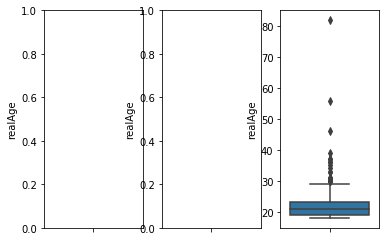

In [14]:
# Age Analysis
fig, axis = plt.subplots(1, 3)
sns.boxplot(y=file_london['realAge'], ax=axis[0])
sns.boxplot(y=file_newyork['realAge'], ax=axis[1])
sns.boxplot(y=file_singapore['realAge'], ax=axis[2])
plt.show()

In [15]:
print(file_london['ageGroup'].unique(), file_newyork['ageGroup'].unique(), file_singapore['ageGroup'].unique())

[nan] [nan] [nan 'AGE10_20' 'AGE20_30' 'AGE30_40' 'AGE40_50' 'AGE50_INF']


###### Testing Ground Delete This

In [16]:
test_df = file_singapore.dropna(thresh=5, axis=0)
test_df.head()

,educationInfoForAgeGroupEstimation,workInfoForAgeGroupEstimation,gender,realAge,ageGroup,relationship,educationLevel,occupation,income,city
2,"St Patrick&#039;s School, Singapore Class of 2...",NaN,male,NaN,AGE10_20,single,college,NaN,NaN,Singapore
5,Alok Study Group Bandung SMAK TRIMULIA Bandung...,NaN,male,27.0,AGE20_30,single,NaN,NaN,NaN,Singapore
10,Guangyang Secondary School Singapore,Singapore Armed Forces,male,NaN,NaN,NaN,school,NaN,NaN,Singapore
11,"Ngee Ann Polytechnic Clementi, Singapore Yuan ...",NaN,female,NaN,AGE10_20,NaN,college,NaN,NaN,Singapore
13,CHIJ Toa Payoh Singapore CHIJ Secondary Toa Payoh,Marina Bay Sands Waitress 2012 to present,female,NaN,NaN,NaN,NaN,food preparation and service related,NaN,Singapore


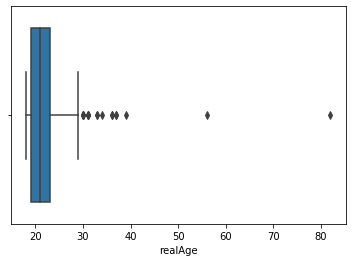

In [17]:
sns.boxplot(test_df['realAge'])

In [18]:
file_singapore['gender'].unique()

array(['female', 'male', nan], dtype=object)

### Data Pre Processing

In [0]:
class PreProcessor:
    """
    Takes a raw DataFrame as input and returns a cleaned and processor
    """
    def __init__(self, nan_drop_threshold=5, train=True, gender_dict=gender_dict, age_group_dict=age_group_dict,
                 city_dict=city_dict):
        self.nan_drop_threshold = nan_drop_threshold
        self.train = train
        self.unknown_token = 'UNKNOWN'

        # Label Encoder for Labels
        self.gender_encoder = LabelEncoder()
        self.age_group_encoder = LabelEncoder()
        self.relationship_encoder = LabelEncoder()
        self.education_encoder = LabelEncoder()
        self.occupation_encoder = LabelEncoder()
        self.income_encoder = LabelEncoder()
        self.city_encoder = LabelEncoder()

        # Count Vectorizer for Input Fields
        self.cv = CountVectorizer()

    def _clean_train(self, dataframe):

        dataframe.dropna(thresh=5, axis=0, inplace=True)

        # Unknown Tokens
        dataframe.fillna(self.unknown_token, inplace=True)

        # -------------------- Labels --------------------

        # Quantize Gender
        dataframe['gender'] = self.gender_encoder.fit_transform(dataframe['gender'])
        
        # Quantize known and UNKNOWN age groups
        dataframe['ageGroup']= self.age_group_encoder.fit_transform(dataframe['ageGroup'])

        # Qunatize Relationship
        dataframe['relationship'] = self.relationship_encoder.fit_transform(dataframe['relationship'])

        # Quantize Education level
        dataframe['educationLevel'] = self.education_encoder.fit_transform(dataframe['educationLevel'])

        # Quantize Occupation Level
        dataframe['occupation'] = self.occupation_encoder.fit_transform(dataframe['occupation'])

        # Quantize Income
        dataframe['income'] = self.income_encoder.fit_transform(dataframe['income'])

        # Quantize City
        dataframe['city'] = self.city_encoder.fit_transform(dataframe['city'])

        # ------------------- Training Fields ---------------

        # Update educationInfoForAgeGroupEstimation to CountVectorizing
        dataframe['educationInfoForAgeGroupEstimation'] = dataframe['educationInfoForAgeGroupEstimation'].str.lower()
        # dataframe['educationInfoForAgeGroupEstimation'] = self.cv.fit_transform(dataframe['educationInfoForAgeGroupEstimation']).toarray()

        # Update workInfoForAgeGroupEstimation to Count Vectorizing 
        dataframe['workInfoForAgeGroupEstimation'] = dataframe['workInfoForAgeGroupEstimation'].str.lower()
        # dataframe['workInfoForAgeGroupEstimation'] = self.cv.fit_transform(dataframe['workInfoForAgeGroupEstimation']).toarray()

        X_train = sp.hstack(dataframe[['educationInfoForAgeGroupEstimation', 'workInfoForAgeGroupEstimation']].apply(lambda col: self.cv.fit_transform(col)))
        
        # Drop Real Age
        dataframe.drop(['realAge'], axis=1, inplace=True)

        return X_train, dataframe


    def _clean_test(self, dataframe):

        # Unknown Tokens
        dataframe.fillna(self.unknown_token, inplace=True)

        # -------------------- Labels --------------------

        # Quantize Gender
        dataframe['gender'] = self.gender_encoder.transform(dataframe['gender'])
        
        # Quantize known and UNKNOWN age groups
        dataframe['ageGroup']= self.age_group_encoder.transform(dataframe['ageGroup'])

        # Qunatize Relationship
        dataframe['relationship'] = self.relationship_encoder.transform(dataframe['relationship'])

        # Quantize Education level
        dataframe['educationLevel'] = self.education_encoder.transform(dataframe['educationLevel'])

        # Quantize Occupation Level
        dataframe['occupation'] = self.occupation_encoder.transform(dataframe['occupation'])

        # Quantize Income
        dataframe['income'] = self.income_encoder.transform(dataframe['income'])

        # Quantize City
        dataframe['city'] = self.city_encoder.transform(dataframe['city'])

        # ------------------- Training Fields ---------------

        # Update educationInfoForAgeGroupEstimation to CountVectorizing
        # dataframe['educationInfoForAgeGroupEstimation'] = self.cv.transform(dataframe['educationInfoForAgeGroupEstimation'])

        # Update workInfoForAgeGroupEstimation to Count Vectorizing 
        # dataframe['workInfoForAgeGroupEstimation'] = self.cv.transform(dataframe['workInfoForAgeGroupEstimation'])

        X_test = sp.hstack(dataframe[['educationInfoForAgeGroupEstimation', 'workInfoForAgeGroupEstimation']].apply(lambda col: self.cv.transform(col)))

        
        # Drop Real Age
        dataframe.drop(['realAge'], axis=1, inplace=True)

        return X_test, dataframe

    def fit(self, dataframe):
        """
        The Clean method will clean the dataframe 
        Operations Performed:
        * Remove the Rows with more than 5 nan's if Train set
        * Mark NAN's with Unknown Tokens
        * Replace Gender to numeric values
        * Replace Age Group to numeric values
        * Replace Relationship to numeric values
        * Replace Education Level to numeric values
        * Replace Occupation Level to numeric values
        * Replace Income to numeric values
        * Replace City to numeric values
        * Count Vectorize Education Info
        * Count Vectorize Work Info

        Parameters:
        dataframe: Pandas DataFrame

        Output:
        dataframe: Pandas DataFrame
        """

        if self.train:
            X, dataframe = self._clean_train(dataframe)
        else:
            X, dataframe = self._clean_test(dataframe)


        return X, dataframe


        


In [0]:
pre_processor_train = PreProcessor()

In [0]:
X_data, Y_data = pre_processor_train.fit(train_data)

In [0]:
Y_data = Y_data.loc[:, ['gender', 'ageGroup', 'relationship',  'city']]

## Classic ML Classifiers

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=SEED)

In [26]:
X_train.shape, y_train.shape

((2434, 19109), (2434, 4))

### Support Vector Machines

In [0]:
# Initialize SVC for all predictions
gender_svm = SVC(kernel='poly')
age_group_svm = SVC(kernel='rbf')
relationship_svm = SVC(kernel='rbf')
city_svm = SVC(kernel='rbf')

In [46]:
gender_svm.fit(X_train, y_train['gender'])
age_group_svm.fit(X_train, y_train['ageGroup'])
relationship_svm.fit(X_train, y_train['relationship'])
city_svm.fit(X_train, y_train['city'])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
gender_svm_output = gender_svm.predict(X_test)
age_group_svm_output = age_group_svm.predict(X_test)
relationship_svm_output = relationship_svm.predict(X_test)
city_svm_output = city_svm.predict(X_test)

In [48]:
gender_svm_f1 = f1_score(gender_svm_output, y_test['gender'], average='weighted')
age_group_svm_f1 = f1_score(age_group_svm_output, y_test['ageGroup'], average='weighted')
relationship_svm_f1 = f1_score(relationship_svm_output, y_test['relationship'], average='weighted')
city_svm_f1 = f1_score(city_svm_output, y_test['city'], average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [49]:
print('-------------- F1 Matrices --------------')
print('Gender: \t\t{:.4f}'.format(gender_svm_f1))
print('AgeGroup: \t\t{:.4f}'.format(age_group_svm_f1))
print('relationship_f1: \t{:.4f}'.format(relationship_svm_f1))
print('city_f1: \t\t{:.4f}'.format(city_svm_f1))

-------------- F1 Matrices --------------
Gender: 		0.7672
AgeGroup: 		0.7953
relationship_f1: 	0.7339
city_f1: 		0.7075


### Random Forest

In [0]:
# Initialize Random Forest Classifier for all predictions
gender_rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)
age_group_rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)
relationship_rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)
city_rfc = RandomForestClassifier(n_estimators=1000, random_state=SEED)

In [38]:
gender_rfc.fit(X_train, y_train['gender'])
age_group_rfc.fit(X_train, y_train['ageGroup'])
relationship_rfc.fit(X_train, y_train['relationship'])
city_rfc.fit(X_train, y_train['city'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [0]:
gender_rfc_output = gender_rfc.predict(X_test)
age_group_rfc_output = age_group_rfc.predict(X_test)
relationship_rfc_output = relationship_rfc.predict(X_test)
city_rfc_output = city_rfc.predict(X_test)

In [50]:
gender_rfc_f1 = f1_score(gender_rfc_output, y_test['gender'], average='weighted')
age_group_rfc_f1 = f1_score(age_group_rfc_output, y_test['ageGroup'], average='weighted')
relationship_rfc_f1 = f1_score(relationship_rfc_output, y_test['relationship'], average='weighted')
city_rfc_f1 = f1_score(city_rfc_output, y_test['city'], average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [51]:
print('-------------- F1 Matrices --------------')
print('Gender: \t\t{:.4f}'.format(gender_rfc_f1))
print('AgeGroup: \t\t{:.4f}'.format(age_group_rfc_f1))
print('relationship_f1: \t{:.4f}'.format(relationship_rfc_f1))
print('city_f1: \t\t{:.4f}'.format(city_rfc_f1))

-------------- F1 Matrices --------------
Gender: 		0.7213
AgeGroup: 		0.8255
relationship_f1: 	0.6827
city_f1: 		0.8461


### Multi-Layer Preceptron

In [0]:
# Initialize Random Forest Classifier for all predictions
gender_mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10)
age_group_mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10)
relationship_mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10)
city_mlp = MLPClassifier(verbose=True, early_stopping=True, n_iter_no_change=10)

In [0]:
gender_mlp.fit(X_train, y_train['gender'])
age_group_mlp.fit(X_train, y_train['ageGroup'])
relationship_mlp.fit(X_train, y_train['relationship'])
city_mlp.fit(X_train, y_train['city'])

In [0]:
gender_mlp_output = gender_mlp.predict(X_test)
age_group_mlp_output = age_group_mlp.predict(X_test)
relationship_mlp_output = relationship_mlp.predict(X_test)
city_mlp_output = city_mlp.predict(X_test)

In [58]:
gender_mlp_f1 = f1_score(gender_mlp_output, y_test['gender'], average='weighted')
age_group_mlp_f1 = f1_score(age_group_mlp_output, y_test['ageGroup'], average='weighted')
relationship_mlp_f1 = f1_score(relationship_mlp_output, y_test['relationship'], average='weighted')
city_mlp_f1 = f1_score(city_mlp_output, y_test['city'], average='weighted')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [59]:
print('-------------- F1 Matrices --------------')
print('Gender: \t\t{:.4f}'.format(gender_mlp_f1))
print('AgeGroup: \t\t{:.4f}'.format(age_group_mlp_f1))
print('relationship_f1: \t{:.4f}'.format(relationship_mlp_f1))
print('city_f1: \t\t{:.4f}'.format(city_mlp_f1))

-------------- F1 Matrices --------------
Gender: 		0.6420
AgeGroup: 		0.7822
relationship_f1: 	0.6565
city_f1: 		0.8673


## Ensembling Models